In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Read Dataset 

In [10]:
!mkdir -p /content/UrbanSound8K
!tar -xvzf "/content/drive/MyDrive/UrbanSound8K.tar.gz" -C /content


## Functions for visualization


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import IPython.display as ipd

metadata = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')

def load_audio(file_path):
    signal, sr = librosa.load(file_path, sr=None)
    return signal, sr

def plot_waveform(signal, sr):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(signal, sr=sr)
    plt.title("Waveform")
    plt.show()

def plot_melspectrogram(signal, sr):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.title("Mel-Spectrogram")
    plt.colorbar()
    plt.show()



In [13]:
metadata

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

## Display 10 different sample from 10 different classes

/tmp/ipython-input-14-3388975247.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = metadata.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)



🎧 Example 1/10 — Class: air_conditioner
File: 162103-0-0-13.wav


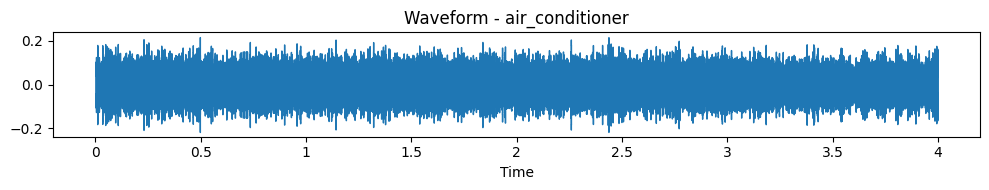

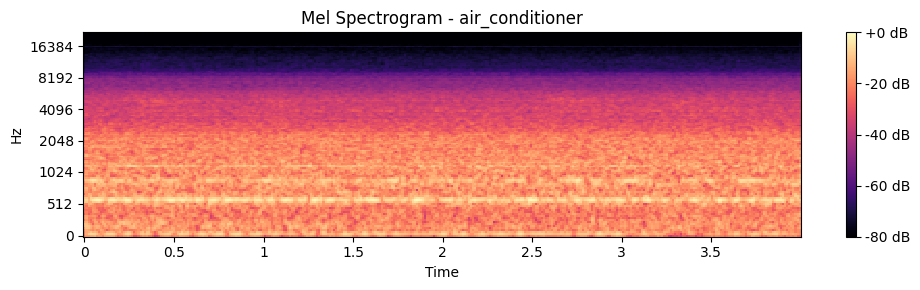


🎧 Example 2/10 — Class: car_horn
File: 28808-1-0-5.wav


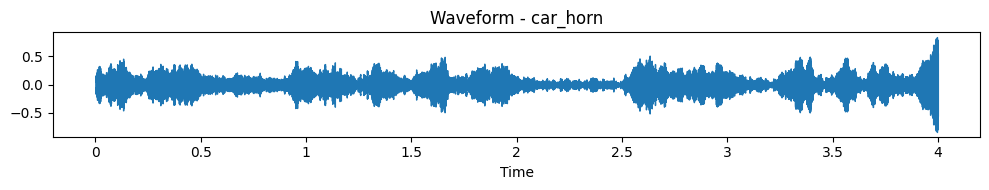

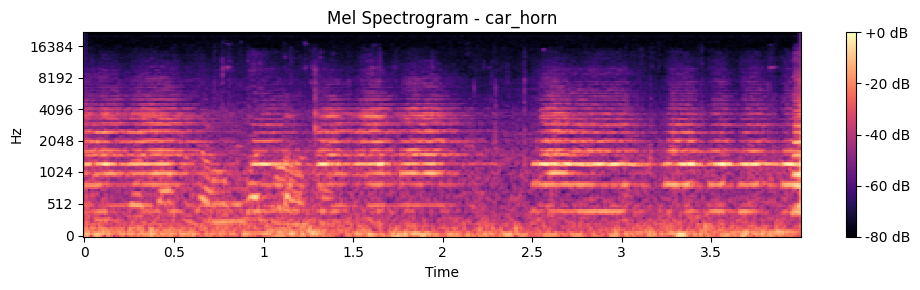


🎧 Example 3/10 — Class: children_playing
File: 155238-2-0-97.wav


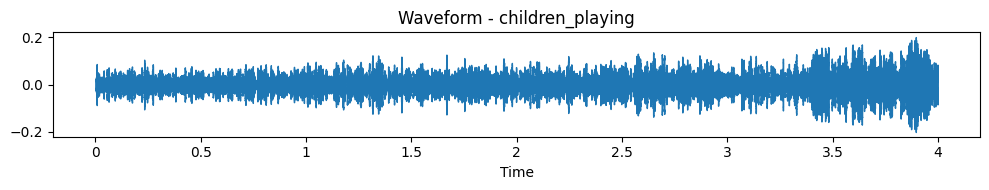

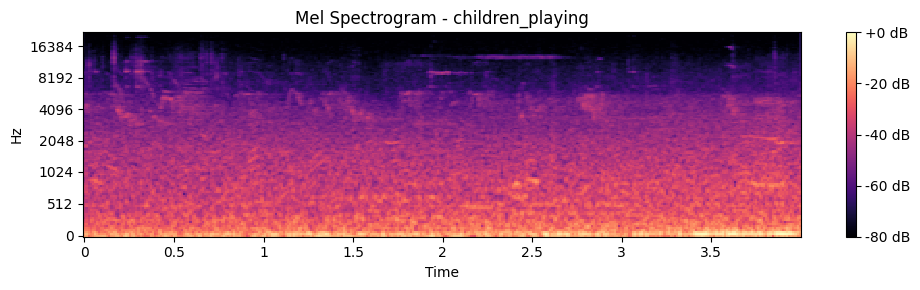


🎧 Example 4/10 — Class: dog_bark
File: 57105-3-4-4.wav


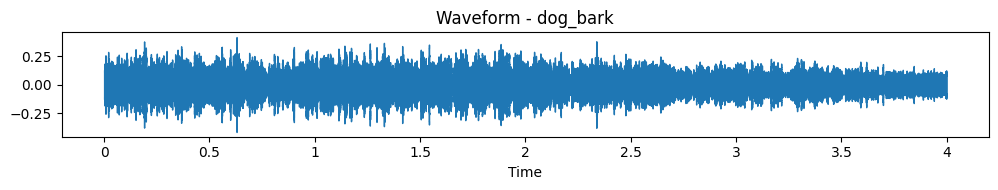

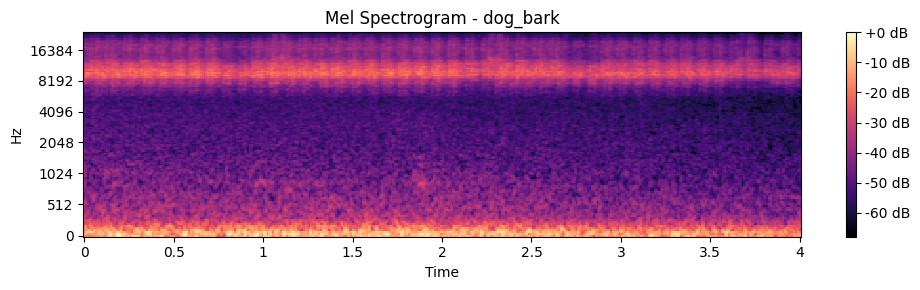


🎧 Example 5/10 — Class: drilling
File: 34621-4-26-0.wav


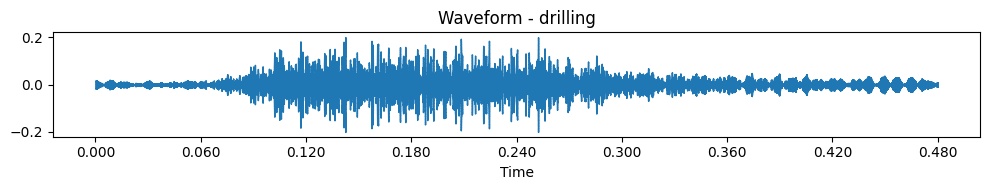

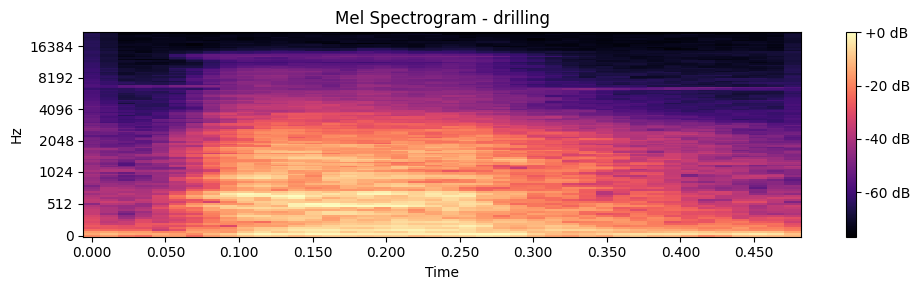


🎧 Example 6/10 — Class: engine_idling
File: 106015-5-0-11.wav


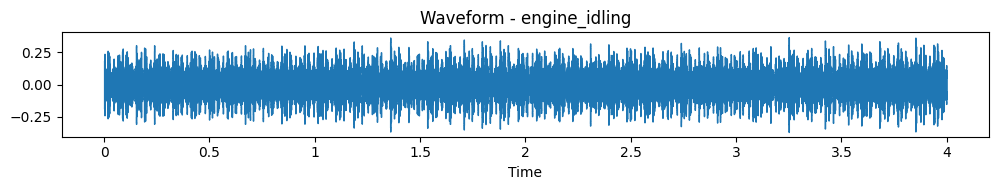

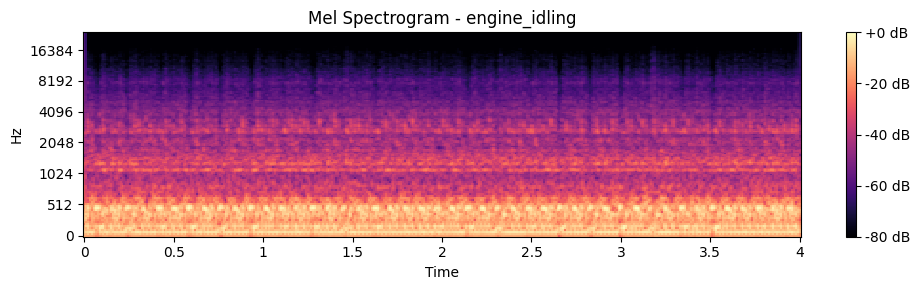


🎧 Example 7/10 — Class: gun_shot
File: 148166-6-0-0.wav


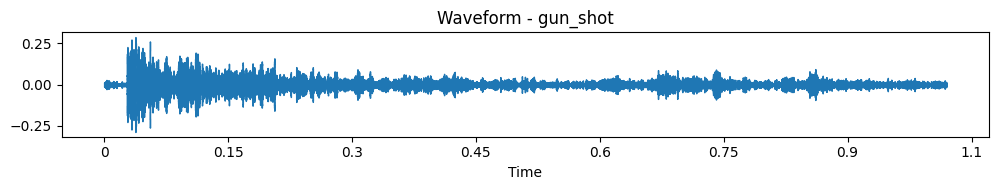

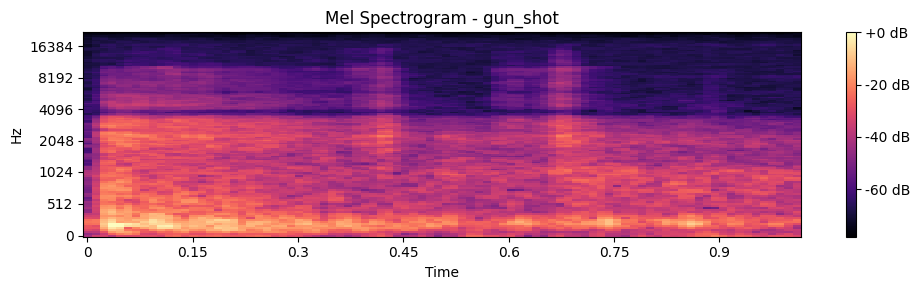


🎧 Example 8/10 — Class: jackhammer
File: 125678-7-1-2.wav


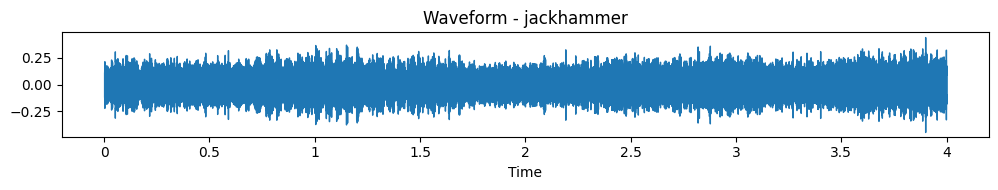

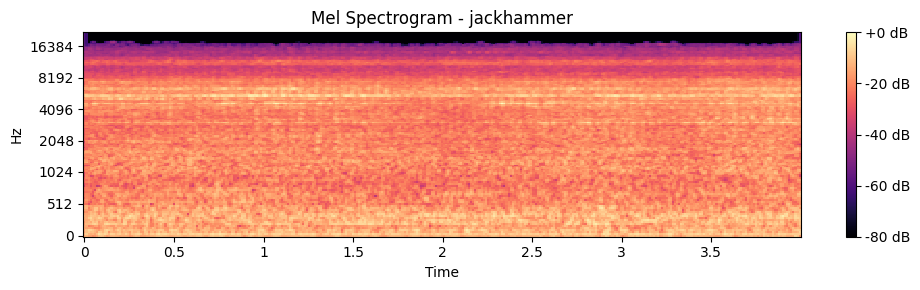


🎧 Example 9/10 — Class: siren
File: 184623-8-0-2.wav


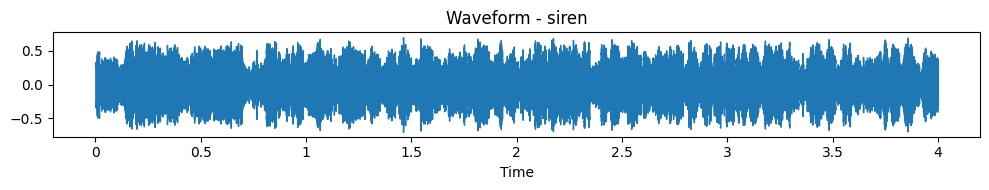

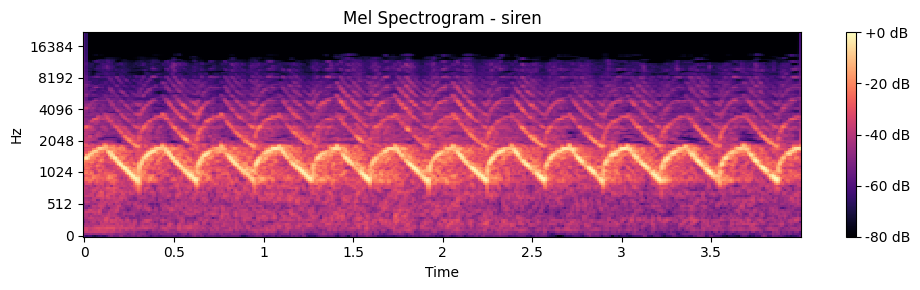


🎧 Example 10/10 — Class: street_music
File: 44325-9-0-18.wav


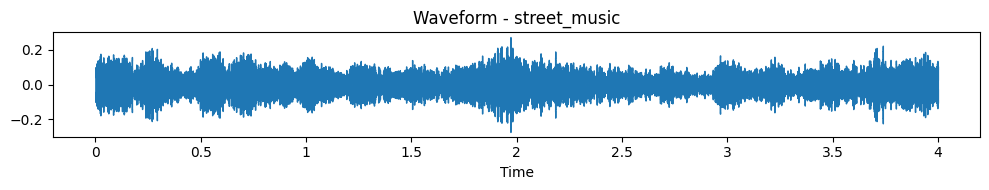

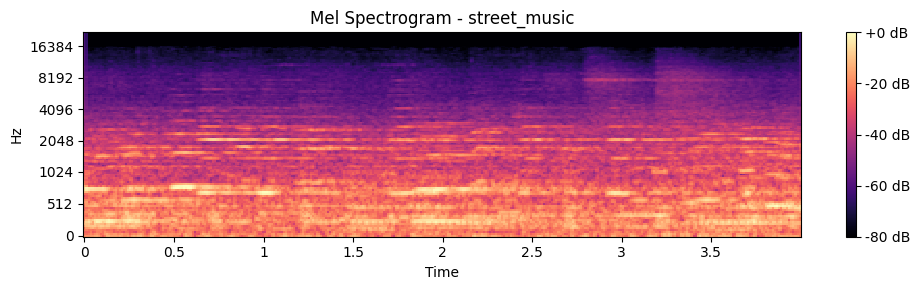

In [14]:
# Visualize and listen to one random sample from each class

# Number of unique classes
num_classes = metadata['class'].nunique()

# Sample one file from each class
samples = metadata.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Base path to the audio folder
AUDIO_BASE_PATH = './UrbanSound8K/audio'

# Loop over each sample and visualize
for i, row in samples.iterrows():
    file_name = row['slice_file_name']
    fold = row['fold']
    class_label = row['class']

    file_path = os.path.join(AUDIO_BASE_PATH, f"fold{fold}", file_name)
    print(f"\n🎧 Example {i+1}/{num_classes} — Class: {class_label}")
    print(f"File: {file_name}")

    # Load audio
    y, sr = librosa.load(file_path, sr=None)

    # Play audio
    display(ipd.Audio(y, rate=sr))

    # Plot waveform
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {class_label}")
    plt.tight_layout()
    plt.show()

    # Plot Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 3))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - {class_label}")
    plt.tight_layout()
    plt.show()


## Extract Features 

In [15]:
def extract_features(signal, sr):
    features = []

    # MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    features.extend(mfcc_mean)

    # Delta + Delta-Delta
    delta = librosa.feature.delta(mfcc, width=5)
    delta2 = librosa.feature.delta(mfcc, order=2 , width=5)
    features.extend(np.mean(delta, axis=1))
    features.extend(np.mean(delta2, axis=1))

    # Spectral features
    spec_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr)
    spec_flat = librosa.feature.spectral_flatness(y=signal)
    spec_roll = librosa.feature.spectral_rolloff(y=signal, sr=sr)

    features.extend([
        np.mean(spec_centroid),
        np.mean(spec_bw),
        np.mean(spec_flat),
        np.mean(spec_roll)
    ])

    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(signal)
    features.append(np.mean(zcr))

    # RMS Energy
    rms = librosa.feature.rms(y=signal)
    features.append(np.mean(rms))

    return np.array(features)

def prepare_dataset(folds):
    X, y = [], []
    for _, row in metadata.iterrows():
        if row['fold'] in folds:
            file_path = f"./UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"
            signal, sr = librosa.load(file_path, sr=None)
            label = row['classID']
            features = extract_features(signal , sr)
            X.append(features)
            y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = prepare_dataset([1,2,3,4,5,6])
X_val, y_val = prepare_dataset([7,8])
X_test, y_test = prepare_dataset([9,10])


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


## BiLSTM

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class BiRNNModel(nn.Module):
    def __init__(self, sequence_length=45, input_size=1, hidden_size=64, num_layers=1, num_classes=10):
        super(BiRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        # hidden_size is doubled because of bidirectional
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size] = [B, 45, 1]
        _, (hn, _) = self.lstm(x)
        forward = hn[-2, :, :]  # [B, hidden_size]
        backward = hn[-1, :, :]  # [B, hidden_size]
        combined = torch.cat((forward, backward), dim=1)  # [B, 2*hidden_size]
        return self.fc(combined)

def train_model_rnn(model, train_loader, val_loader, epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb.float())
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb.float())
            _, predicted = torch.max(outputs.data, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()

    val_accuracy = correct / total
    return model, val_accuracy


### Take the input on 40 time steps "feature per time step" 

In [19]:
# Example reshape: (N, 45, 1)
X_train = X_train.reshape(X_train.shape[0], 45, 1)
X_val = X_val.reshape(X_val.shape[0], 45, 1)
X_test = X_test.reshape(X_test.shape[0], 45, 1)

from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=32)


### Try different hidden sizes and number of layers Using 50 epochs
Best config: hidden_size = 128, num_layers = 1 with Validation Accuracy = 0.4824


In [ ]:
hidden_sizes = [64, 128, 256, 512]
num_layers_list = [1, 2, 4 , 6]

best_config_rnn = None
best_val_accuracy = 0.0

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        print(f"\nTraining with hidden_size = {hidden_size}, num_layers = {num_layers}")

        model = BiRNNModel(
            sequence_length=45,
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=10
        )

        trained_model, val_accuracy = train_model_rnn(model, train_loader, val_loader)

        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_config_rnn = (hidden_size, num_layers, trained_model)

print(f"\nBest config: hidden_size = {best_config_rnn[0]}, num_layers = {best_config_rnn[1]} with Validation Accuracy = {best_val_accuracy:.4f}")


### BiLSTM Evaluation
Accuracy: 0.4737, F1 Score: 0.4668


Accuracy: 0.4737, F1 Score: 0.4668


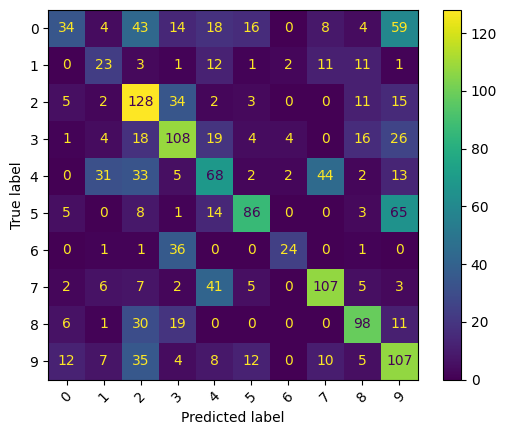

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X, y):
    model.eval()
    device = next(model.parameters()).device

    if not torch.is_tensor(X):
        X = torch.tensor(X).float()

    # Reshape to (num_samples, 45, 1) for BiLSTM input
    if X.ndim == 2:
        X = X.view(-1, 45, 1)
    elif X.ndim == 3 and X.shape[1] != 45:
        raise ValueError(f"Expected sequence length 45, got {X.shape[1]} instead.")
    elif X.ndim != 3:
        raise ValueError(f"Expected input to be 2D or 3D, got {X.ndim}D instead")

    X = X.to(device)

    with torch.no_grad():
        preds = model(X).argmax(dim=1).cpu().numpy()

    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average='weighted')
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    cm = confusion_matrix(y, preds)
    ConfusionMatrixDisplay(cm).plot(xticks_rotation=45)
    plt.show()

# Example usage:
evaluate_model(best_config_rnn[2], X_test, y_test)


## Transformer

### Positional encoding using sin & cos 

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [21]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv_proj(x).chunk(3, dim=-1)
        q, k, v = [t.view(B, T, self.num_heads, self.d_k).transpose(1, 2) for t in qkv]
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(self.dropout(out))


In [22]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x


###  TransformerClassifier  
This class defines a complete Transformer-based model for sequence classification, which consists of:

- **Input Embedding**:  
  Projects input features from `input_dim` to `d_model` using a linear layer.  

- **Positional Encoding**:  
  Adds positional information to the embedded input to retain sequence order.  

- **Stacked Transformer Encoder Blocks**:  
  A configurable number (`num_layers`) of `TransformerBlock` layers, each including:  
  - Multi-head self-attention  
  - Feed-forward network  
  - Layer normalization  
  - Residual connections  
  - Dropout  

- **Global Sequence Pooling**:  
  Applies `AdaptiveAvgPool1d` to collapse the sequence dimension and produce a fixed-size feature vector.  

- **Classification Head**:  
  A final linear layer maps the pooled output to `num_classes` class logits.  


In [23]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, d_ff, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)


In [24]:
def train_model_transformer(model, train_loader, val_loader, epochs=50, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device).float(), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    return model, val_acc



In [29]:
def evaluate_model(model, X, y):
    device = next(model.parameters()).device
    model.eval()
    if not torch.is_tensor(X):
        X = torch.tensor(X).float()
    X = X.to(device)
    with torch.no_grad():
        preds = model(X).argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average='weighted')
    cm = confusion_matrix(y, preds)
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    ConfusionMatrixDisplay(cm).plot(xticks_rotation=45)
    plt.show()


### Train the transformer trying different configurations

**Try with the same data used in the Bilstm**
- Best config: d_model=256, num_heads=2, d_ff=256, num_layers=4 with Validation Accuracy=0.3248

- Accuracy: 0.4011, F1 Score: 0.3940


In [ ]:
d_model_list = [128 , 256 , 512]
num_heads_list = [2, 4]
d_ff_list = [128 , 256]
num_layers_list = [4 , 6]

best_config = None
best_val_accuracy = 0.0

for d_model in d_model_list:
    for num_heads in num_heads_list:
        for d_ff in d_ff_list:
            for num_layers in num_layers_list:
                print(f"\nTraining with d_model={d_model}, num_heads={num_heads}, d_ff={d_ff}, num_layers={num_layers}")
                model = TransformerClassifier(
                    input_dim=X_train.shape[-1],
                    d_model=d_model,
                    num_heads=num_heads,
                    d_ff=d_ff,
                    num_layers=num_layers,
                    num_classes=10
                )
                model, val_acc = train_model_transformer(model, train_loader, val_loader)
                print(f"Validation Accuracy: {val_acc:.4f}")
                if val_acc > best_val_accuracy:
                    best_val_accuracy = val_acc
                    best_config = (d_model, num_heads, d_ff, num_layers, model)

print(f"\nBest config: d_model={best_config[0]}, num_heads={best_config[1]}, d_ff={best_config[2]}, num_layers={best_config[3]} with Validation Accuracy={best_val_accuracy:.4f}")


Accuracy: 0.4011, F1 Score: 0.3940


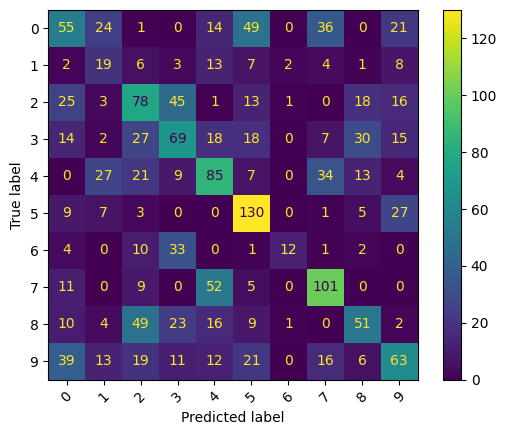

In [31]:
#without reshaping seq length =45
# Evaluate
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

evaluate_model(best_config[4], X_test, y_test)

**Trying sequence length 9 and input size 5**
- Best config: d_model=256, num_heads=2, d_ff=256, num_layers=4 with Validation Accuracy=0.33

- Accuracy: 0.4120, F1 Score: 0.4086


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_traintf = X_train.reshape(X_train.shape[0], 9, 5)
X_valtf = X_val.reshape(X_val.shape[0], 9, 5)
X_testf = X_test.reshape(X_test.shape[0], 9, 5)

train_loadertf = DataLoader(TensorDataset(torch.tensor(X_traintf, dtype=torch.float32),
                                          torch.tensor(y_train, dtype=torch.long)), batch_size=32, shuffle=True)
val_loadertf = DataLoader(TensorDataset(torch.tensor(X_valtf, dtype=torch.float32),
                                        torch.tensor(y_val, dtype=torch.long)), batch_size=32)


In [ ]:
# Transformer config search
d_model_list = [128 , 256 , 512]
num_heads_list = [2, 4]
d_ff_list = [128 , 256]
num_layers_list = [4 , 6]

best_configtf = None
best_val_accuracytf = 0.0

for d_model in d_model_list:
    for num_heads in num_heads_list:
        for d_ff in d_ff_list:
            for num_layers in num_layers_list:
                print(f"\nTraining with d_model={d_model}, num_heads={num_heads}, d_ff={d_ff}, num_layers={num_layers}")

                model = TransformerClassifier(
                    input_dim=X_traintf.shape[-1],
                    d_model=d_model,
                    num_heads=num_heads,
                    d_ff=d_ff,
                    num_layers=num_layers,
                    num_classes=10
                )

                model, val_acc = train_model_transformer(model, train_loadertf, val_loadertf)
                print(f"Validation Accuracy: {val_acc:.4f}")

                if val_acc > best_val_accuracytf:
                    best_val_accuracytf = val_acc
                    best_configtf = (d_model, num_heads, d_ff, num_layers, model)

print(f"\nBest config: d_model={best_configtf[0]}, num_heads={best_configtf[1]}, d_ff={best_configtf[2]}, num_layers={best_configtf[3]} with Validation Accuracy={best_val_accuracytf:.4f}")


Accuracy: 0.4120, F1 Score: 0.4086


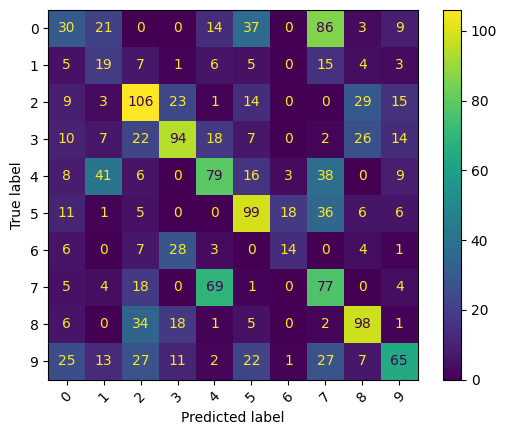

In [40]:
#Reshape without scaling
evaluate_model(best_configtf[4], X_testf, y_test)

 **Scaling with reshaping**

- Best config: d_model=256, num_heads=4, d_ff=256, num_layers=4 with Validation Accuracy=0.3425
- Accuracy: 0.3521, F1 Score: 0.3395


In [57]:
from sklearn.preprocessing import StandardScaler
X_traintf = X_train.reshape(X_train.shape[0], 9, 5)
X_valtf = X_val.reshape(X_val.shape[0], 9, 5)
X_testf = X_test.reshape(X_test.shape[0], 9, 5)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_traintf.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_valtf.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_testf.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

train_loader_tf = DataLoader(TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader_tf = DataLoader(TensorDataset(torch.tensor(X_val_scaled), torch.tensor(y_val)), batch_size=32)



In [53]:
d_model_list = [128 , 256 , 512]
num_heads_list = [2, 4]
d_ff_list = [128 , 256]
num_layers_list = [4 , 6]

best_config_scaled = None
best_val_accuracy_scaled = 0.0

for d_model in d_model_list:
    for num_heads in num_heads_list:
        for d_ff in d_ff_list:
            for num_layers in num_layers_list:
                print(f"\nTraining with d_model={d_model}, num_heads={num_heads}, d_ff={d_ff}, num_layers={num_layers}")
                model = TransformerClassifier(
                    input_dim=X_train_scaled.shape[-1],
                    d_model=d_model,
                    num_heads=num_heads,
                    d_ff=d_ff,
                    num_layers=num_layers,
                    num_classes=10
                )
                model, val_acc = train_model_transformer(model, train_loader_tf, val_loader_tf)
                print(f"Validation Accuracy: {val_acc:.4f}")
                if val_acc > best_val_accuracy_scaled:
                    best_val_accuracy_scaled = val_acc
                    best_config_scaled = (d_model, num_heads, d_ff, num_layers, model)

print(f"\nBest config: d_model={best_config_scaled[0]}, num_heads={best_config_scaled[1]}, d_ff={best_config_scaled[2]}, num_layers={best_config_scaled[3]} with Validation Accuracy={best_val_accuracy_scaled:.4f}")



Training with d_model=128, num_heads=2, d_ff=128, num_layers=4
Epoch 1/50 - Loss: 2.2255
Epoch 2/50 - Loss: 2.1187
Epoch 3/50 - Loss: 2.1316
Epoch 4/50 - Loss: 2.0789
Epoch 5/50 - Loss: 2.1198
Epoch 6/50 - Loss: 2.2176
Epoch 7/50 - Loss: 2.0998
Epoch 8/50 - Loss: 2.0494
Epoch 9/50 - Loss: 2.1476
Epoch 10/50 - Loss: 1.8832
Epoch 11/50 - Loss: 2.3220
Epoch 12/50 - Loss: 2.1127
Epoch 13/50 - Loss: 1.7012
Epoch 14/50 - Loss: 1.4558
Epoch 15/50 - Loss: 1.9818
Epoch 16/50 - Loss: 1.2312
Epoch 17/50 - Loss: 1.7555
Epoch 18/50 - Loss: 1.4980
Epoch 19/50 - Loss: 1.8345
Epoch 20/50 - Loss: 1.5012
Epoch 21/50 - Loss: 1.5104
Epoch 22/50 - Loss: 1.7236
Epoch 23/50 - Loss: 1.8414
Epoch 24/50 - Loss: 1.3352
Epoch 25/50 - Loss: 1.4956
Epoch 26/50 - Loss: 1.7220
Epoch 27/50 - Loss: 1.7229
Epoch 28/50 - Loss: 1.2160
Epoch 29/50 - Loss: 1.5852
Epoch 30/50 - Loss: 1.4376
Epoch 31/50 - Loss: 1.5675
Epoch 32/50 - Loss: 1.5699
Epoch 33/50 - Loss: 1.3849
Epoch 34/50 - Loss: 1.5142
Epoch 35/50 - Loss: 1.4091


Accuracy: 0.3521, F1 Score: 0.3395


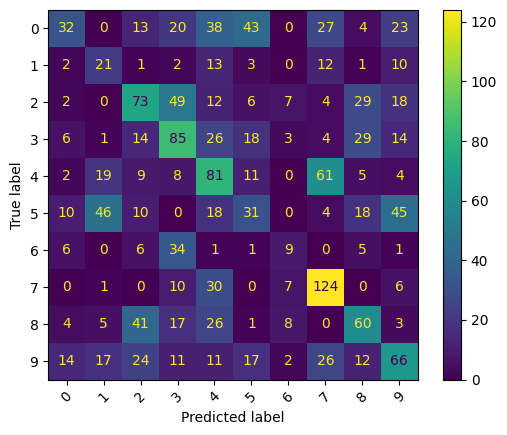

In [54]:
#Scaling with reshaping
evaluate_model(best_config_scaled[4], X_test_scaled, y_test)

### **Scaling without reshaping "one time step"**
- Accuracy: 0.5566, F1 Score: 0.5459
- Best config: d_model=512, num_heads=4, d_ff=128, num_layers=6 with Validation Accuracy=0.5821


In [59]:
from sklearn.preprocessing import StandardScaler
X_train_wor = X_train.reshape(X_train.shape[0], 1, 45)
X_val_wor = X_val.reshape(X_val.shape[0],  1, 45)
X_test_wor = X_test.reshape(X_test.shape[0], 1, 45)


scaler = StandardScaler()
X_train_wor = scaler.fit_transform(X_train_wor.reshape(-1, X_train_wor.shape[-1])).reshape(X_train_wor.shape)
X_val_wor = scaler.transform(X_val_wor.reshape(-1, X_val_wor.shape[-1])).reshape(X_val_wor.shape)
X_test_wor = scaler.transform(X_test_wor.reshape(-1, X_test_wor.shape[-1])).reshape(X_test_wor.shape)

train_loader_wor = DataLoader(TensorDataset(torch.tensor(X_train_wor), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader_wor = DataLoader(TensorDataset(torch.tensor(X_val_wor), torch.tensor(y_val)), batch_size=32)



In [61]:
d_model_list = [128 , 256 , 512]
num_heads_list = [2, 4]
d_ff_list = [128 , 256]
num_layers_list = [4 , 6]

best_config_wor = None
best_val_accuracy_wor = 0.0

for d_model in d_model_list:
    for num_heads in num_heads_list:
        for d_ff in d_ff_list:
            for num_layers in num_layers_list:
                print(f"\nTraining with d_model={d_model}, num_heads={num_heads}, d_ff={d_ff}, num_layers={num_layers}")
                model = TransformerClassifier(
                    input_dim=X_train_wor.shape[-1],
                    d_model=d_model,
                    num_heads=num_heads,
                    d_ff=d_ff,
                    num_layers=num_layers,
                    num_classes=10
                )
                model, val_acc = train_model_transformer(model, train_loader_wor, val_loader_wor)
                print(f"Validation Accuracy: {val_acc:.4f}")
                if val_acc > best_val_accuracy_wor:
                    best_val_accuracy_wor = val_acc
                    best_config_wor = (d_model, num_heads, d_ff, num_layers, model)

print(f"\nBest config: d_model={best_config_wor[0]}, num_heads={best_config_wor[1]}, d_ff={best_config_wor[2]}, num_layers={best_config_wor[3]} with Validation Accuracy={best_val_accuracy_wor:.4f}")



Training with d_model=128, num_heads=2, d_ff=128, num_layers=4
Epoch 1/50 - Loss: 1.4570
Epoch 2/50 - Loss: 1.0829
Epoch 3/50 - Loss: 1.1529
Epoch 4/50 - Loss: 0.8932
Epoch 5/50 - Loss: 0.8381
Epoch 6/50 - Loss: 1.0999
Epoch 7/50 - Loss: 0.3987
Epoch 8/50 - Loss: 0.5854
Epoch 9/50 - Loss: 0.8706
Epoch 10/50 - Loss: 0.5773
Epoch 11/50 - Loss: 0.7253
Epoch 12/50 - Loss: 0.6753
Epoch 13/50 - Loss: 0.5107
Epoch 14/50 - Loss: 0.3993
Epoch 15/50 - Loss: 0.2997
Epoch 16/50 - Loss: 0.2730
Epoch 17/50 - Loss: 0.3941
Epoch 18/50 - Loss: 0.4276
Epoch 19/50 - Loss: 0.5149
Epoch 20/50 - Loss: 0.3372
Epoch 21/50 - Loss: 0.3224
Epoch 22/50 - Loss: 0.2901
Epoch 23/50 - Loss: 0.3501
Epoch 24/50 - Loss: 0.3259
Epoch 25/50 - Loss: 0.2275
Epoch 26/50 - Loss: 0.2094
Epoch 27/50 - Loss: 0.1927
Epoch 28/50 - Loss: 0.1545
Epoch 29/50 - Loss: 0.2498
Epoch 30/50 - Loss: 0.3380
Epoch 31/50 - Loss: 0.1620
Epoch 32/50 - Loss: 0.1346
Epoch 33/50 - Loss: 0.1813
Epoch 34/50 - Loss: 0.2282
Epoch 35/50 - Loss: 0.1518


Accuracy: 0.5566, F1 Score: 0.5459


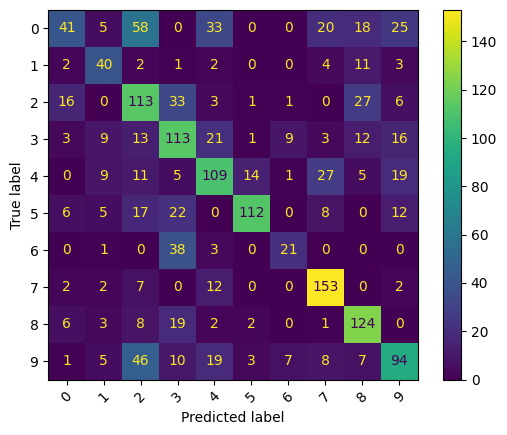

In [62]:
#Scaling without reshaping "one step"
evaluate_model(best_config_wor[4], X_test_wor, y_test)